## Dataset I. target_dataset
<br>
<img src="./images/target_dataset.png"/>

Explanation for the columns:
1. `person` (int)
    - Id for person: already encoded to int number
2. `offer_id` (object of str)
    - Id for offer: already encoded to int number
    - **Values**: from '0' to '9'
3. `time_received` (float)
    - time of reveiving the offer
    - **Values**: `NaN` represent not received
4. `time_viewed` (float) 
    - time of viewing the offer
    - **Values**: `NaN` represent not viewed
5. `time_transaction` (object of str)
    - time of the transactions within an transaction unit(within one unique offer_id of one person, there may be more transaction units)
    - **Values**: there maybe more than one transactions within a transaction unit, so use `str`(obeject) to represent
        - `''` means there is no transaction
        - `',3.8,5.9'` means there is two transactions, one is at time 3.8, another in at time 5.9
6. `time_completed` (float)
    - time of complete the offer
    - **Values**: `NaN` represent not completed
7. `amount_with_offer` (float)
    - amount of transaction(s) within this transaction unit
    - **Values**: '0.0' represent no transaction
8. `label_effective_offer` (int)
    - the label to mark the completion level of offer
    - **Values**:
        - `1`: 
            - for informational offer there is at least one transaction within duration; 
            - for other offer there should be 'offer completed'
        - `0`: 
            - for informational offer there is no transaction but 'offer received'; 
            - for other offers there is no 'offer completed', but within duration there maybe some amount, although the amount of transactions not fulfil requirements
        - `-1`: the init label, when there is no 'offer received', the label keeps '-1'
        - `-2`: Special, some interesting discovering after the data was wrangled
            - represent some people: they only have transactions within all the experimantal time , no offer was sent to them

## Dataset II. transcript_offer(updated)

```python
### Code
# Just show the updated part:
normal_offer_id = target_dataset.offer_id.unique().tolist()   # ['0','1','2','3','4','5','6','7','8','9']
# show transaction, the offer_id is not normal(some has been updated by wrangling)
transcript_offer[~transcript_offer.offer_id.isin(normal_offer_id)].tail(20)
```
<img src="./images/transcript_offer.png"/>
Some values in column 'offer_id' are updated.<br>
In figure, the value '6,5' represent:<br>
　　this transaction is valid for two offer_ids: one is '6', another is '5'.


[TOC]


# <a class="anchor" id="0">Table of Contents</a>

I. [Feature Engineer](#1)<br>
II.[Segement of the Person](#2)<br>
III.[NAME](#3)<br>
　　3.1. [NAME](#3.1)<br>
　　　　Method.1 [NAME](#3.1.1)<br>
　　　　Method.2 [NAME](#3.1.2) (better for debugging)<br>
　　3.2. [Save the wrangled data](#3.2)<br>
IV.[Explore the wrangled Data](#4)(preliminary)<br>
[References](#References)

### Imports & Load in data

In [1]:
import pandas as pd
import numpy as np
import math
import json

from time import time
from datetime import date
from collections import defaultdict

import matplotlib.pyplot as plt
%matplotlib inline

# detail for offers
portfolio_raw = pd.read_csv('./data_generated/cleaned_portfolio.csv', dtype={'offer_id': str})
del portfolio_raw['Unnamed: 0']

# detail for person
profile_raw = pd.read_csv('./data_generated/cleaned_profile.csv')
del profile_raw['Unnamed: 0']

# wrangled transcript with updated information of offer
transcript_offer_raw = pd.read_csv('./data_generated/wrangled_transcript_offer.csv', dtype={'person': int})
# recover to original dataset: index is the same
transcript_offer_raw.index = transcript_offer_raw.iloc[:, 0].values
del transcript_offer_raw['Unnamed: 0']

# wrangled ideal target_dataset
target_dataset_raw = pd.read_csv('./data_generated/modified_wrangled_target_dataset.csv', dtype={'person': int, 'offer_id': str})
# recover to original dataset: index is the same
target_dataset_raw.index = target_dataset_raw.iloc[:, 0].values
del target_dataset_raw['Unnamed: 0']

In [3]:
portfolio = portfolio_raw.copy()
profile = profile_raw.copy()
transcript_offer = transcript_offer_raw.copy()
target_dataset = target_dataset_raw.copy()

In [36]:
profile = profile_raw.copy()

In [37]:
profile

,gender,age,id,became_member_on,income
0,F,55,1,20170715,112000.0
1,F,75,3,20170509,100000.0
2,M,68,5,20180426,70000.0
3,M,65,8,20180209,53000.0
4,M,58,12,20171111,51000.0
...,...,...,...,...,...
14820,F,45,16995,20180604,54000.0
14821,M,61,16996,20180713,72000.0
14822,M,49,16997,20170126,73000.0
14823,F,83,16998,20160307,50000.0


## <a class="anchor" id="1">[I. Feature Engineer](#0)</a>

### 1. Potential feature 
- Transform column 'became_member_on' in `profile`

In [38]:
# rename column for merging
profile.rename(columns={'id': 'person'}, inplace=True)

In [39]:
def transform_date(input_date):
    '''Transform date(int) to normal date(date form)
    '''
    year = int(str(input_date)[:4])
    month = int(str(input_date)[4:6])
    day = int(str(input_date)[-2:])
    actual_date = date(year, month, day)
    
    return actual_date

In [44]:
# create funciton to transform the register date to member_days 
latest_date = profile['became_member_on'].max()  #20180726

def transform_member_days(input_date, latest_date):
    '''Transform the register date to member_days.
    
    INPUT:
        - date (int): the register date, e.g. 20180726
        - latest_date (int): the latest register date, 20180726
    
    OUTPUT:
        - member_days (int): the days apart from the latest new year, 2019.01.01
    '''
    # suppose we use the begin of the next year as the experimental date, here is 2019.01.01
    latest_year = int(str(latest_date)[:4]) + 1  # 2019: used to calculate
    refer_date = date(latest_year, 1, 1)
    
    year = int(str(input_date)[:4])
    month = int(str(input_date)[4:6])
    day = int(str(input_date)[-2:])
    actual_date = date(year, month, day)
    
    # get the date difference to the refer_date
    member_days = (refer_date - actual_date).days

    return member_days


profile['member_days'] = profile['became_member_on'].apply(transform_member_days, args=(latest_date,))
profile['register_date'] = profile['became_member_on'].apply(transform_date)

profile

,gender,age,person,became_member_on,income,member_days,register_date
0,F,55,1,20170715,112000.0,535,2017-07-15
1,F,75,3,20170509,100000.0,602,2017-05-09
2,M,68,5,20180426,70000.0,250,2018-04-26
3,M,65,8,20180209,53000.0,326,2018-02-09
4,M,58,12,20171111,51000.0,416,2017-11-11
...,...,...,...,...,...,...,...
14820,F,45,16995,20180604,54000.0,211,2018-06-04
14821,M,61,16996,20180713,72000.0,172,2018-07-13
14822,M,49,16997,20170126,73000.0,705,2017-01-26
14823,F,83,16998,20160307,50000.0,1030,2016-03-07


In [52]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.hist(data=profile, x='register_date')
plt.title('Distribution of register date')
plt.xlabel('register date')

plt.subplot(1,2,2)
plt.hist(data=profile, x='member_days')
plt.title('Distribution of days as a member')
plt.xlabel('days from register date to latest new year(2019.01.01)')

plt.show()

# after visualization delete useless columns
profile.drop(columns=['became_member_on', 'register_date'], inplace=True )

### 2. Merge the dataset to combine all the potential features 

In [27]:
target_dataset = target_dataset.merge(portfolio, how='left', on='offer_id').merge(profile, how='left', on='person')

target_dataset

,person,offer_id,time_received,time_viewed,time_transaction,time_completed,amount_with_offer,label_effective_offer,reward,difficulty,duration,offer_type,email,mobile,social,web,gender,age,member_days,income
0,3,3,0.0,0.25,",5.5",5.50,19.89,1,5.0,5.0,7.0,bogo,1.0,1.0,0.0,1.0,F,75,602,100000.0
1,3,7,7.0,9.00,9.25,NaN,19.67,1,0.0,0.0,3.0,informational,1.0,1.0,1.0,0.0,F,75,602,100000.0
2,3,0,17.0,17.00,",21.25",21.25,21.72,1,10.0,10.0,7.0,bogo,1.0,1.0,1.0,0.0,F,75,602,100000.0
3,3,8,21.0,24.25,",21.25",21.25,21.72,1,5.0,5.0,5.0,bogo,1.0,1.0,1.0,1.0,F,75,602,100000.0
4,5,9,0.0,0.75,NaN,NaN,0.00,0,2.0,10.0,7.0,discount,1.0,1.0,0.0,1.0,M,68,250,70000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66501,5639,-1,NaN,NaN,-1,NaN,0.00,-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,66,459,34000.0
66502,15391,-1,NaN,NaN,-1,NaN,0.00,-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M,91,1184,70000.0
66503,872,-1,NaN,NaN,-1,NaN,0.00,-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,72,444,35000.0
66504,14763,-1,NaN,NaN,-1,NaN,0.00,-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,54,725,72000.0


## <a class="anchor" id="2">[II. Segement of the Person](#0)</a>
Since there are too many individuals, it's better to set some customer groups to excavate more common pattern in each group.<br>
According to [References[1]](https://github.com/syuenloh/UdacityDataScientistCapstone/blob/master/Starbucks%20Capstone%20Challenge%20-%20Using%20Starbucks%20app%20user%20data%20to%20predict%20effective%20offers.ipynb) and [References[3]](https://www.pewresearch.org/topics/generations-and-age/), there is a definition of generations based on age in 2019.
<img src="./images/generations_age.png"/>

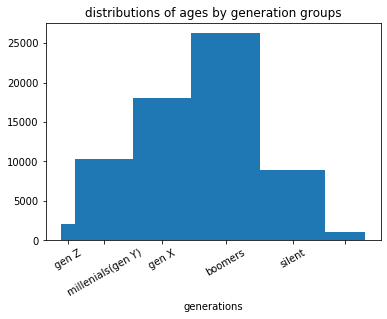

In [73]:
# distribution of age according to the definition of generations
# in 2018 the age edge as bins
age_min=target_dataset.age.min()  #18
age_max=target_dataset.age.max() #101
bins = [age_min, 22, 38, 54, 73, 91, age_max+1]
plt.hist(data=target_dataset, x='age' ,bins=bins);

plt.title('distributions of ages by generation groups')
plt.xlabel('generations')

ticks_loc = [20, 30, 46, 63.5, 82, 96.5]
ticks_label = ['gen Z', 'millenials(gen Y)', 'gen X', 'boomers', 'silent']
plt.xticks(ticks_loc, ticks_label, rotation=30) #rotation=90

plt.show()

Meantime, we can use also other informations(gender, income, member_days etc.) together to divide customer groups.<br>
Since the groups of `gen Z`(18-21) and the elder than `silent` are small, and the age is closed to the generation group nearby, so we finally make the segement as follows:
- age
- gender
<img src='./images/segment.png'>

## <a class="anchor" id="References">[References](#0)</a>
[[1]Starbucks Capstone Challenge: Using Starbucks app user data to predict effective offers](https://github.com/syuenloh/UdacityDataScientistCapstone/blob/master/Starbucks%20Capstone%20Challenge%20-%20Using%20Starbucks%20app%20user%20data%20to%20predict%20effective%20offers.ipynb)<br>
[[2]Starbucks Promotion Optimization](https://towardsdatascience.com/starbucks-promotion-optimization-ca56e29fb584)<br>
[[3]generations-and-age](https://www.pewresearch.org/topics/generations-and-age/)